In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import seaborn as sns
#import geopandas as gpd
#from shapely.geometry import Point
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from sklearn.metrics import confusion_matrix
import datetime as dt   # Python standard library datetime  module

In [12]:
#Creating a fonction to normalize result
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

# Fonction to compute confusion matrix (hits, false_al, misses, correct negatives) and performance indexes (FAR, POD, POFD, CSI)):
# Methodology adapted taking into account the consecutive day above thresholds as a unique flood period
# hits:              nb of peak period above thresholds that have at least one observation day within the period
# false alarm :      number of peak above threshold(consecutive day above discharge threshold as an event), minus the number of hits
# misses :           number of observed flood events no in a discharge peak period o above threshold
# correct negative : forcing the correct negative number to be the same than the number of observed flood events (misses + hits)

def calc_performance_scores(obs, pred):
    
    df= pd.DataFrame({'cons_class': pred.diff().ne(0).cumsum(), 'hits':(obs==1) & (pred ==1),'fal':(obs==0)&(pred==1)})
    hits= df[['cons_class','hits' ]].drop_duplicates().hits[df.hits == True].count()
    false_al = (pred.loc[pred.shift() != pred].sum()) - hits 
    misses = sum((obs==1) & (pred ==0))
    corr_neg = misses + hits
    output = {}
    output['pod'] = hits / (hits + misses)
    output['far'] = false_al / (hits + false_al)
    output['pofd'] = false_al / (false_al + corr_neg)
    output['csi'] = hits / (hits + false_al + misses)
    
    output = pd.Series(output)
    return output

In [13]:
Date_format = '%d/%m/%Y'
#Admin_column = 'County'                      
my_local_path = ''
countries = ['kenya','uganda']
for country in countries:
    path = my_local_path +country + '/' 
    ct_code = country[0:3]
    if (country == 'kenya'):
        flood_events_ken=pd.read_csv(path + 'input/%s_impact_data.csv' %ct_code, encoding='latin-1')  
        flood_events_ken['Date']= pd.to_datetime(flood_events_ken['Date'], format=Date_format) 
        flood_events_ken= flood_events_ken.query("Date >= '2000-01-01' ")                                                              
        flood_events_ken = flood_events_ken[['Date', 'County', 'flood']].drop_duplicates().rename(columns={'County': 'district'}).dropna().set_index('Date')  
        flood_events_ken['district']= flood_events_ken['district'].str.lower() 
        impact_floods_ken = flood_events_ken.reset_index().rename(columns={'Date': 'time'})  
    
        # (2)- open the impacted_area and Glofas related stations per district files
        df_dg_ken=pd.read_csv(path + 'input/%s_affected_area_stations.csv' %ct_code, encoding='latin-1') 
        df_dg_ken['name']= df_dg_ken['name'].str.lower() 
        df_dg_long_ken = df_dg_ken[['name', 'Glofas_st', 'Glofas_st2', 'Glofas_st3', 'Glofas_st4']].melt(id_vars='name', var_name='glofas_n', value_name='station').drop('glofas_n', 1).dropna()
        df_dg_long_ken = df_dg_long_ken.rename(columns = {'name': 'district'})
        df_dg_ken=df_dg_ken.set_index('name')
    

    if (country == 'uganda'):
        flood_events_uga=pd.read_csv(path + 'input/%s_impact_data.csv' %ct_code, encoding='latin-1')  
        flood_events_uga['Date']= pd.to_datetime(flood_events_uga['Date'], format=Date_format) 
        flood_events_uga= flood_events_uga.query("Date >= '2000-01-01' ")                                                              
        flood_events_uga = flood_events_uga[['Date', 'Area', 'flood']].drop_duplicates().rename(columns={'Area': 'district'}).dropna().set_index('Date')  
        flood_events_uga['district']= flood_events_uga['district'].str.lower() 
        impact_floods_uga = flood_events_uga.reset_index().rename(columns={'Date': 'time'})  
    
        # (2)- open the impacted_area and Glofas related stations per district files
        df_dg_uga=pd.read_csv(path + 'input/%s_affected_area_stations.csv' %ct_code, encoding='latin-1') 
        df_dg_uga['name']= df_dg_uga['name'].str.lower() 
        df_dg_long_uga = df_dg_uga[['name', 'Glofas_st', 'Glofas_st2', 'Glofas_st3', 'Glofas_st4']].melt(id_vars='name', var_name='glofas_n', value_name='station').drop('glofas_n', 1).dropna()
        df_dg_long_uga = df_dg_long_uga.rename(columns = {'name': 'district'})
        df_dg_uga=df_dg_uga.set_index('name')

In [14]:
Gl_stations = pd.read_csv('africa/glofas/Glofaspoints_Africa_510.csv')
Gl_stations['station']= Gl_stations['ID']
Gl_stations =Gl_stations[['ID','station', 'Stationnam', 'CountryNam','XCorrected','YCorrected']].set_index('ID').rename(columns={'Stationnam': 'location', 'CountryNam': 'Country','XCorrected': 'lon', 'YCorrected': 'lat'})  
Gl_stations['Q50']= float('NaN')
Gl_stations['Q80']= float('NaN')
Gl_stations['Q90']= float('NaN')
Gl_stations =Gl_stations[['Country','station','location','lon', 'lat','Q50','Q80','Q90']]
my_local_path = ''
di={}
Gl_stations_ken = Gl_stations[Gl_stations['Country']== 'Kenya']
Gl_stations_uga = Gl_stations[Gl_stations['Country']== 'Uganda']
Gl_stations = Gl_stations_ken.append(Gl_stations_uga)
#values_tested = 
def threshold_optimize(station,weight_far=0.5):
#    Gl_stations = Gl_stations[Gl_stations['ID']== station]
    performance_df=pd.DataFrame(columns=['station', 'pod','far','pofd','csi','threshold'])
    Longitude = Gl_stations[Gl_stations['station']==station].lon
    Latitude = Gl_stations[Gl_stations['station']==station].lat
    country = Gl_stations[Gl_stations['station']==station].Country
    if (country.values[0] == 'Kenya'):
        ct_code = 'ken'
        country_nam = 'kenya'
    if (country.values[0] =='Uganda'):
        ct_code = 'uga'
        country_nam = 'uganda'
    path = my_local_path +country_nam + '/' 
    glofas_grid = path +'input/Glofas/%s_glofas_all.nc' %ct_code
    nc= xr.open_dataset(glofas_grid)
    nc_loc=nc.sel(lon=Longitude,lat=Latitude, method='nearest').rename({'dis24':'dis'}) 
    di[station]=nc_loc.dis
    Extreme_dis = nc_loc.dis.groupby('time.year').max('time')
    discharge = []
    extreme_discharge = []
    for i in range (0,len(nc_loc.dis)):
        discharge.append(nc_loc.dis.values[i][0][0])
        if ((i+1)%180 == 0):
            extreme_discharge.append(max(discharge[(i-179):(i+1)]))
    extreme_discharge = np.asarray(extreme_discharge, dtype=np.float32)
    best = 1
    starting_value = 0.5
    ending_value = 0.95
    increment = 0.05
    value_check = starting_value
    while (value_check <= ending_value):
        discharge_threshold = np.quantile(extreme_discharge,value_check)
        df_dis=pd.DataFrame(columns=['station','time', 'dis', 'max_dt_3days'])
        df_dis['time']= di[station]['time'].values
        df_dis['dis']= pd.Series(di[station].values.flatten())  
        df_dis['station'] = station
        df_dis['max_dt_3days']= df_dis.dis.rolling(7, min_periods=3,center=True).max() 
        if (country.values[0] == 'Kenya'):
            df_model = pd.merge(df_dis, df_dg_long_ken, how='left', on='station').dropna()
            df_model = pd.merge(df_model, impact_floods_ken, how='left', on=['time', 'district'])
            df_model['thres_discharge'] = discharge_threshold
            df_model = df_model[df_model['time']> (impact_floods_ken.time.min() - dt.timedelta(days=7))]
            df_model = df_model[df_model['time']< (impact_floods_ken.time.max() + dt.timedelta(days=7))]
            df_model['flood'] = df_model['flood'].fillna(0)
        
        if (country.values[0] == 'Uganda'):
            df_model = pd.merge(df_dis, df_dg_long_uga, how='left', on='station').dropna()
            df_model = pd.merge(df_model, impact_floods_uga, how='left', on=['time', 'district'])
            df_model['thres_discharge'] = discharge_threshold
            df_model = df_model[df_model['time']> (impact_floods_uga.time.min() - dt.timedelta(days=7))]
            df_model = df_model[df_model['time']< (impact_floods_uga.time.max() + dt.timedelta(days=7))] 
            df_model['flood'] = df_model['flood'].fillna(0)
        df_model['predicted'] = np.where((df_model['max_dt_3days'] >= df_model['thres_discharge']), 1, 0)
        perf= df_model.groupby(['station']).apply(lambda row: calc_performance_scores(row['flood'], row['predicted'])).reset_index()
        perf.loc[0,'threshold'] = 'Q' + str(int(100*value_check))
        perf.loc[0,'country'] = country_nam
        performance_df = performance_df.append(perf)
        value_check = value_check + increment
    performance_df['objective_function'] = weight_far*performance_df['far'] + (1-weight_far)*(1-performance_df['pod'])
    return performance_df
    

In [15]:
tot_perf = pd.DataFrame(columns=['station', 'pod','far','pofd','csi','threshold','objective_function','country'])
for station in Gl_stations['station'].unique():
    tot_perf=tot_perf.append(threshold_optimize(station,0.5))

C:\Users\patel\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\patel\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\patel\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

In [20]:
tot_perf = tot_perf.dropna()
tot_perf = tot_perf.reset_index(drop=True)
#tot_perf['threshold'].plot(kind='bar')

,country,csi,far,objective_function,pod,pofd,station,threshold
0,kenya,0.0625,0.860465,0.879385,0.101695,0.385417,G5171,Q50
1,kenya,0.0681818,0.828571,0.863438,0.101695,0.329545,G5171,Q55
2,kenya,0.0609756,0.821429,0.868341,0.0847458,0.280488,G5171,Q60
3,kenya,0.0375,0.875,0.912076,0.0508475,0.2625,G5171,Q65
4,kenya,0.028169,0.857143,0.911622,0.0338983,0.169014,G5171,Q70


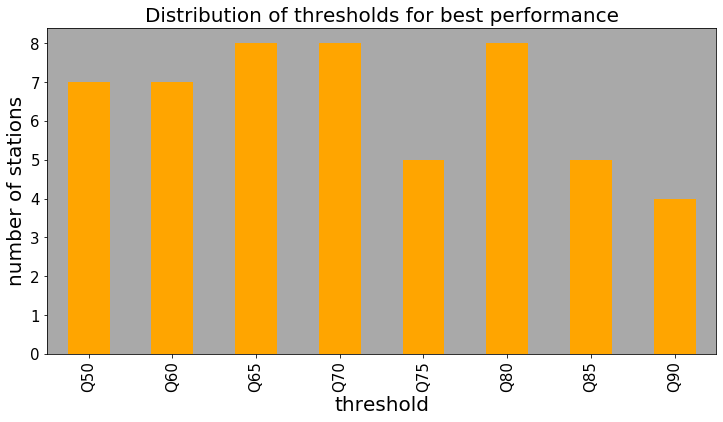

In [90]:
idx = tot_perf.groupby(['station'])['objective_function'].transform(max) == tot_perf['objective_function']
max_performance = tot_perf[idx]
max_performance = max_performance.drop_duplicates(subset='station')
plt.figure(figsize=(12,6))
ax=max_performance.groupby(['threshold']).count()['station'].plot(kind='bar',color='orange')
plt.ylabel('number of stations',fontsize=20)
plt.xlabel('threshold',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_facecolor('darkgray')
plt.title('Distribution of thresholds for best performance',fontsize=20)
max_performance.to_csv('best_performance.csv',index=False)

In [72]:
tot_perf['threshold_num'] = tot_perf['threshold'].str[1:3].astype('int')

C:\Users\patel\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


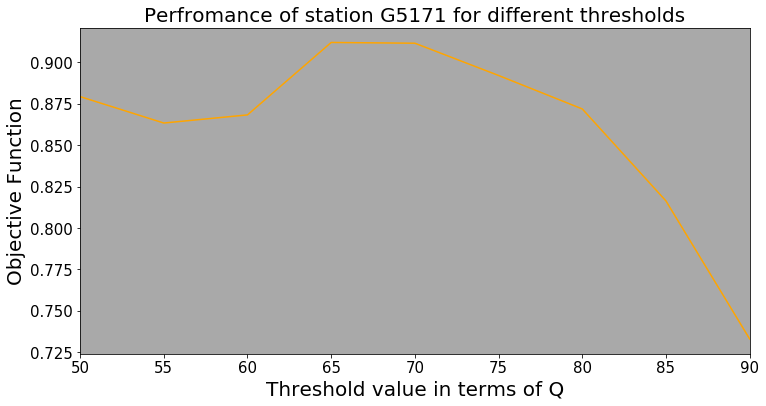

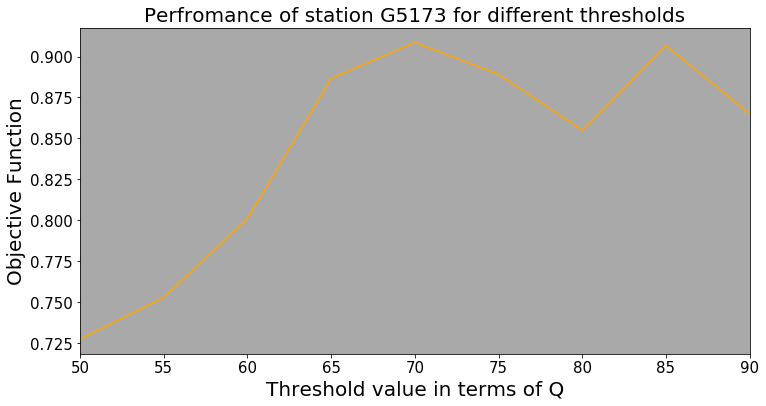

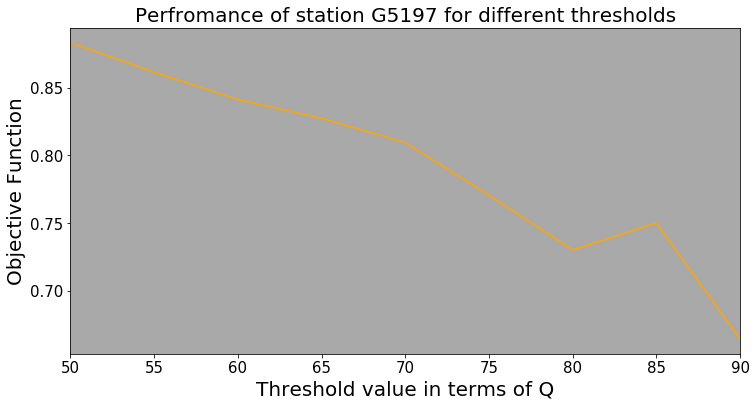

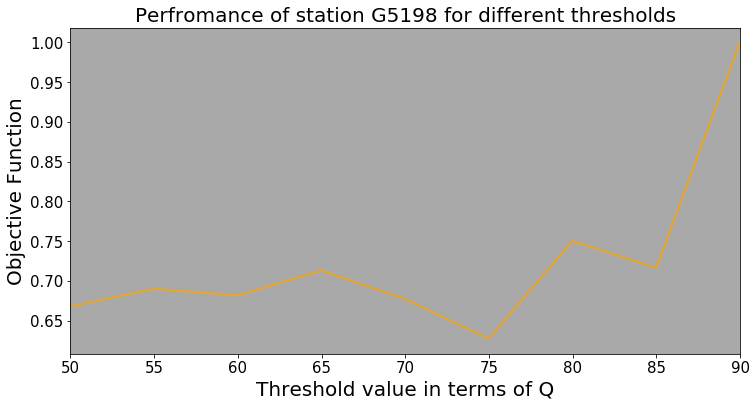

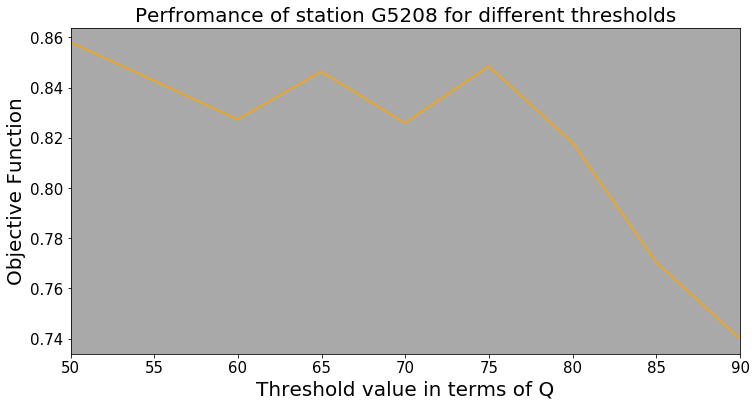

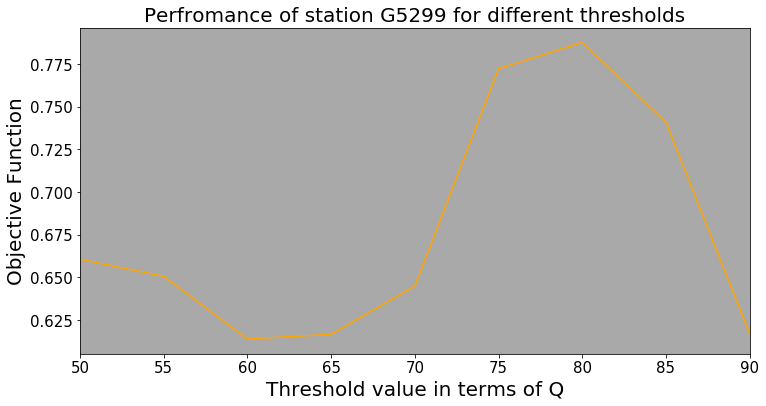

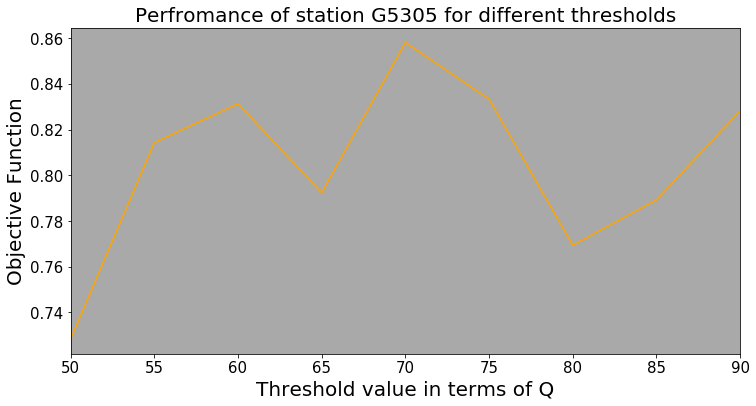

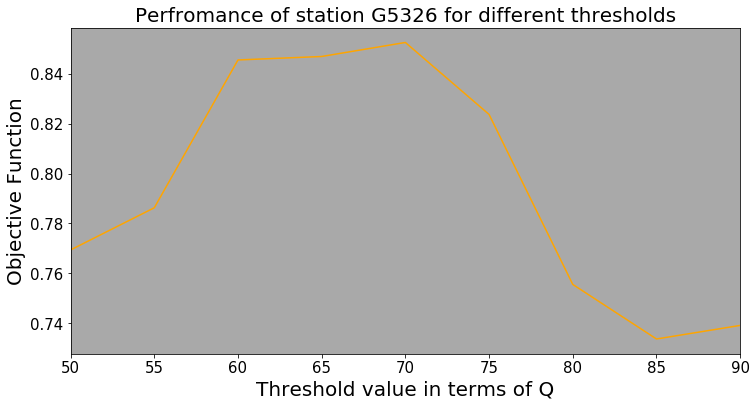

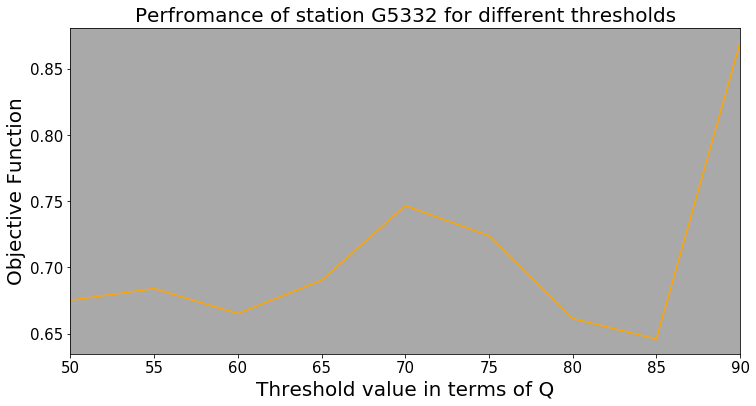

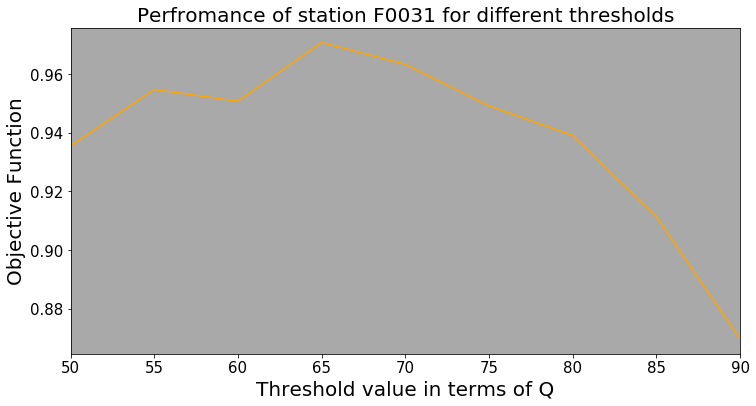

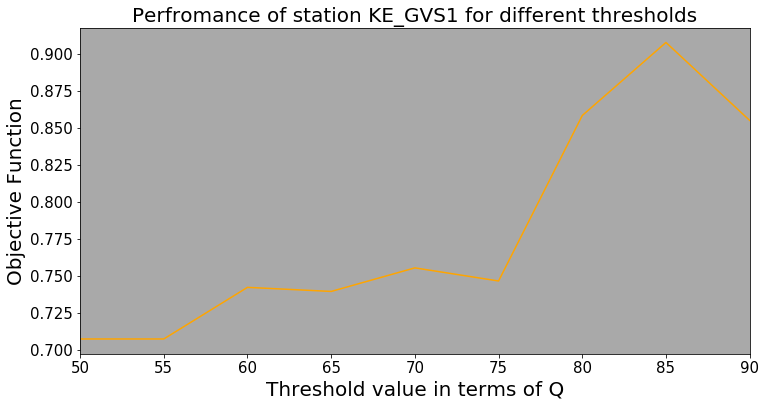

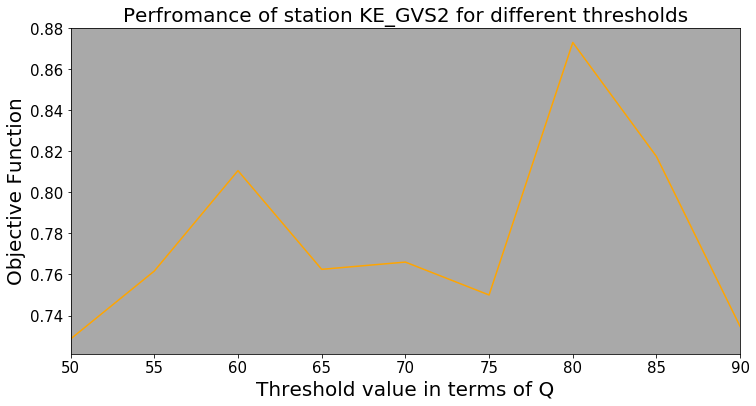

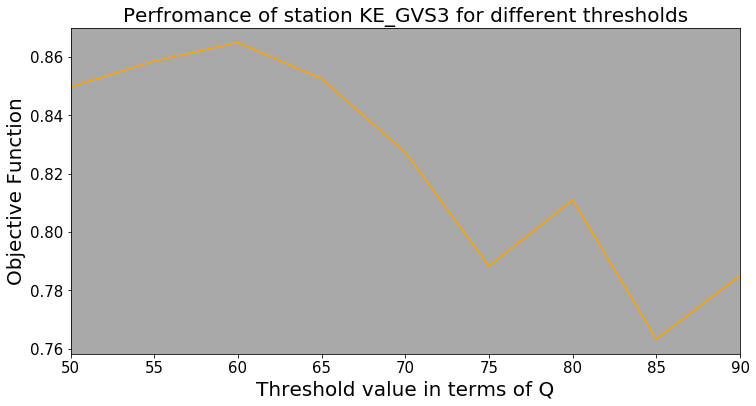

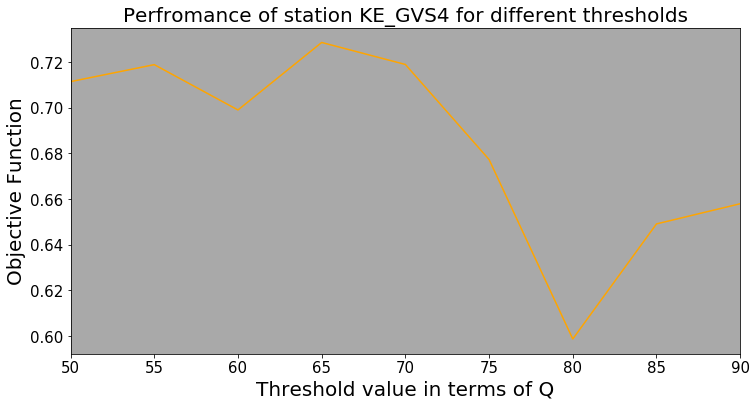

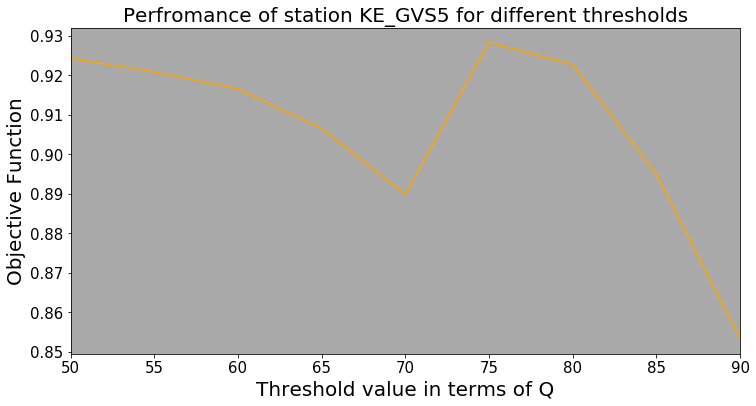

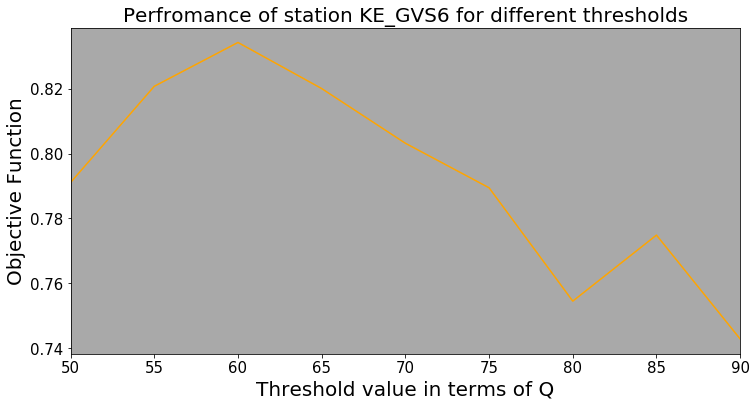

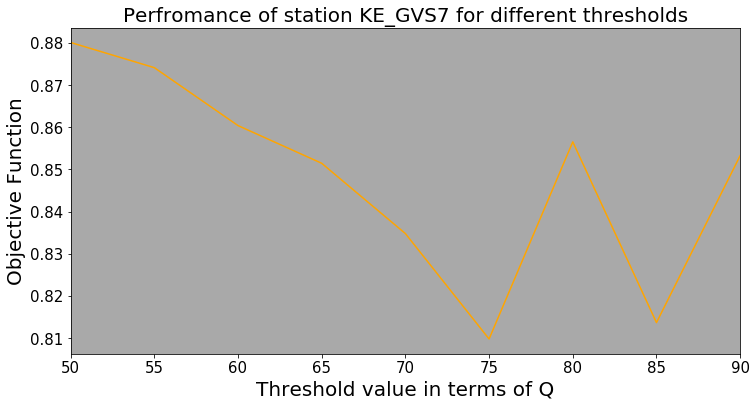

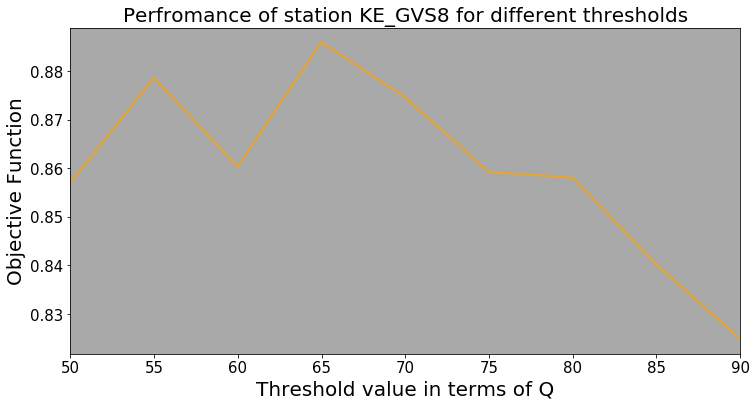

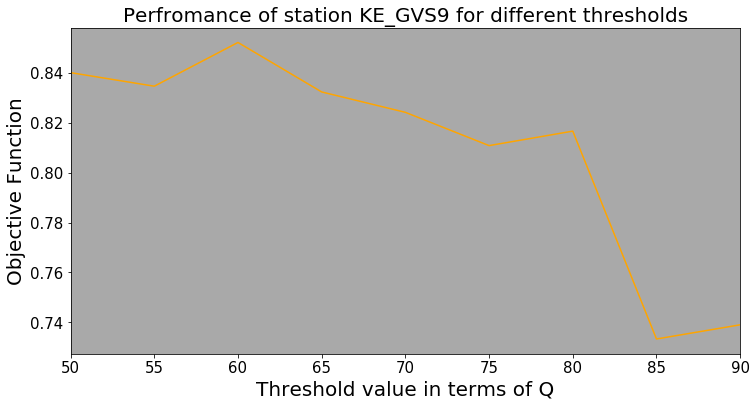

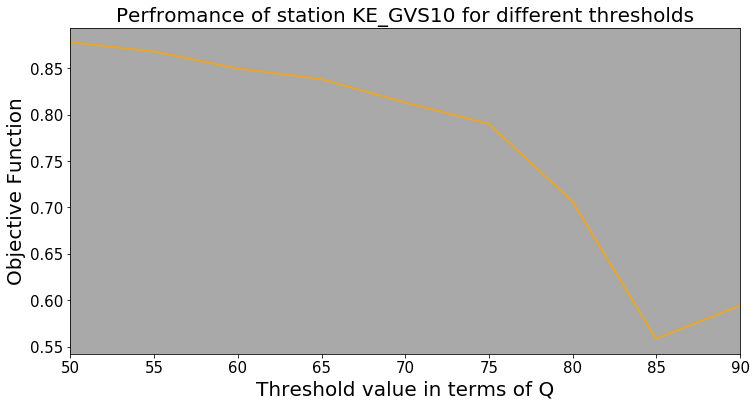

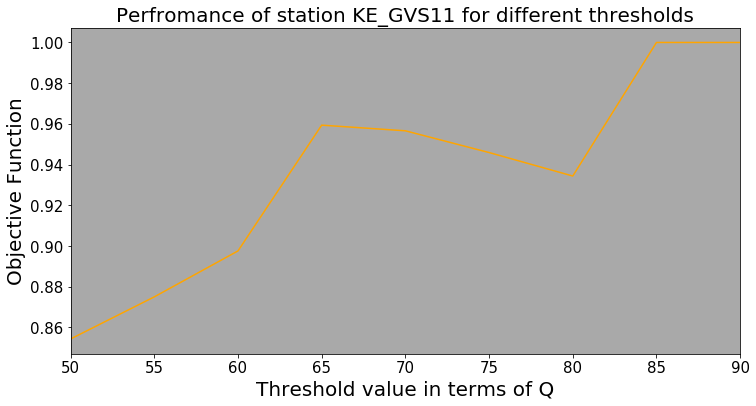

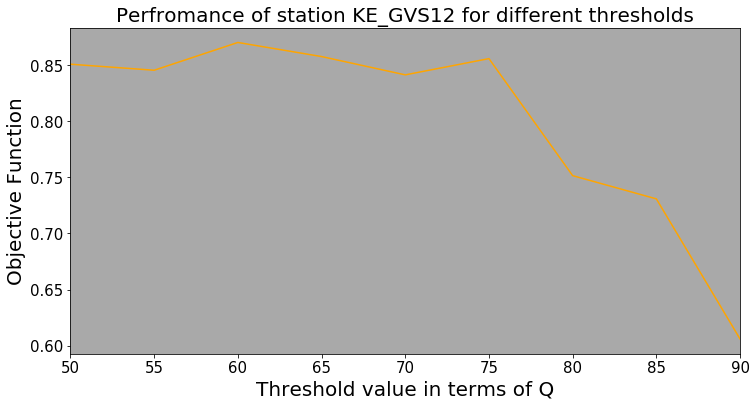

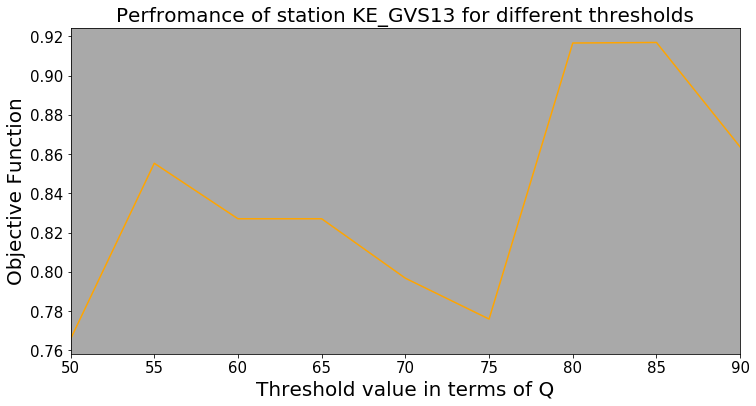

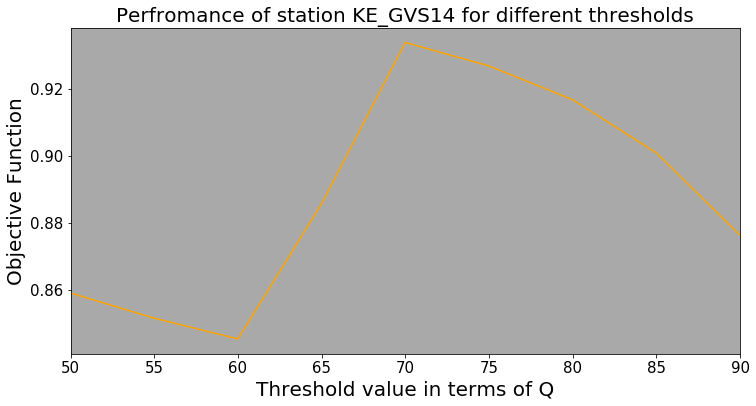

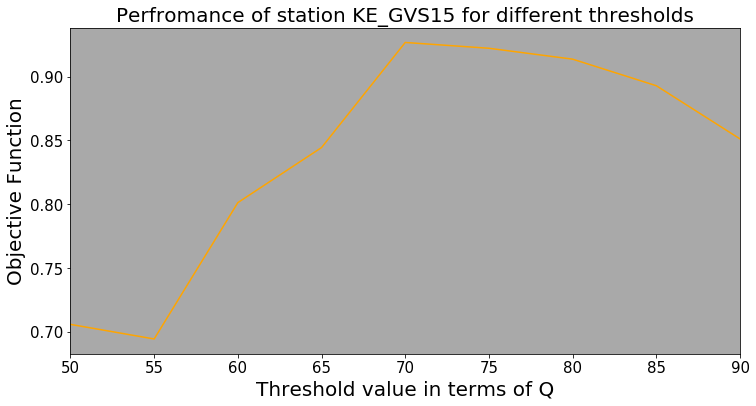

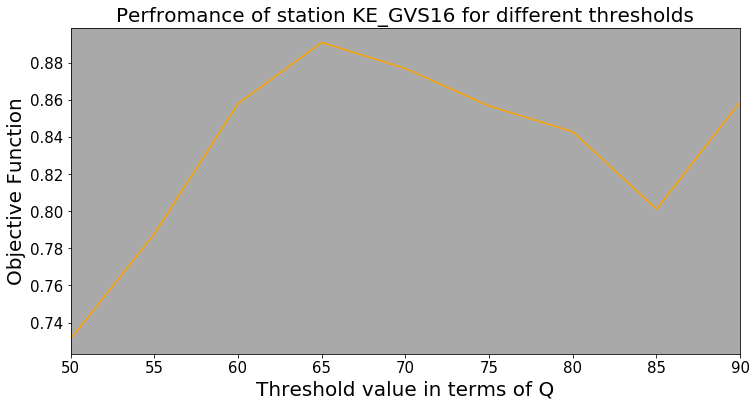

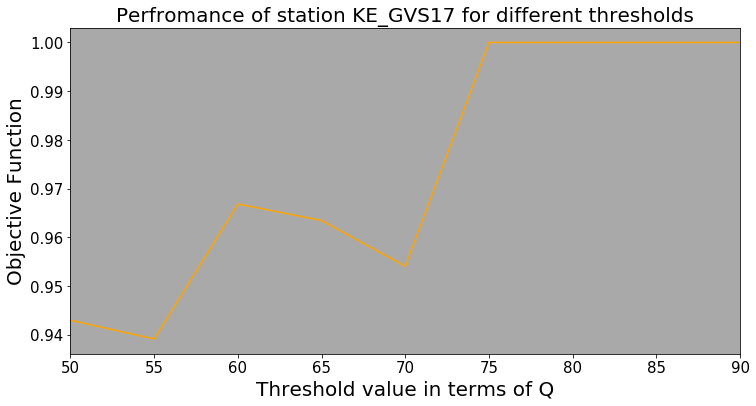

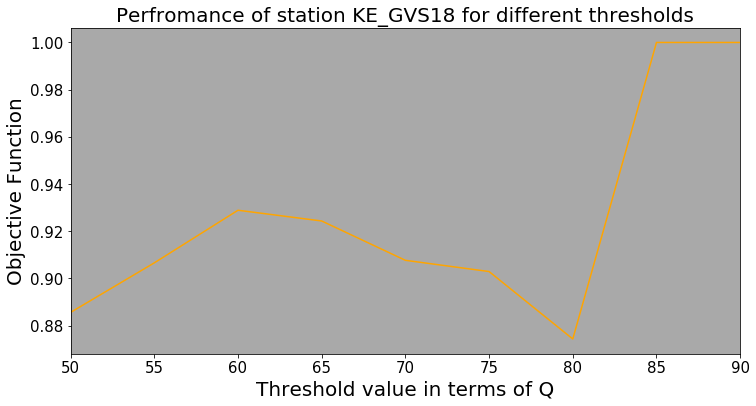

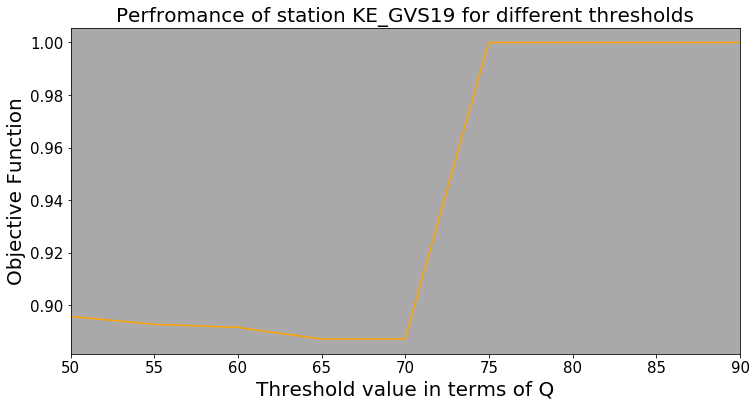

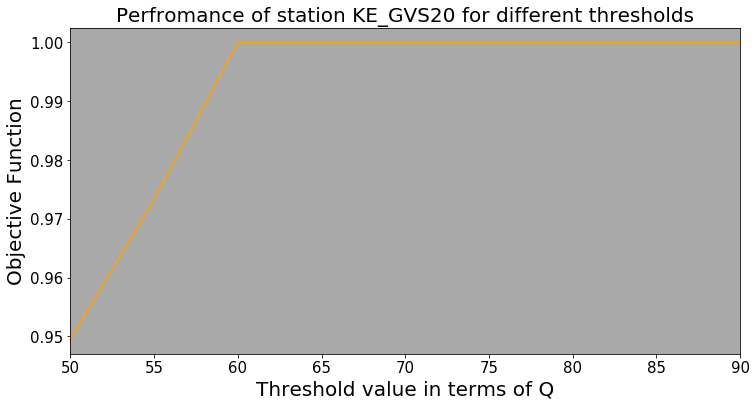

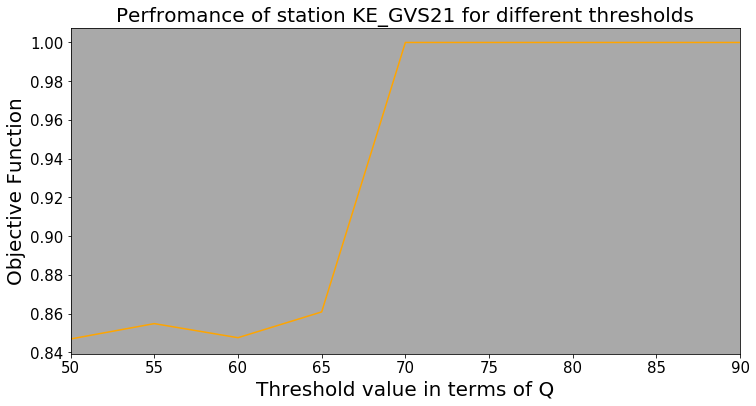

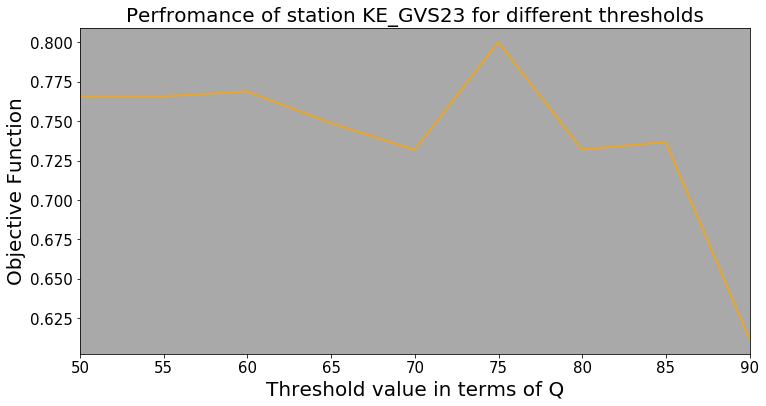

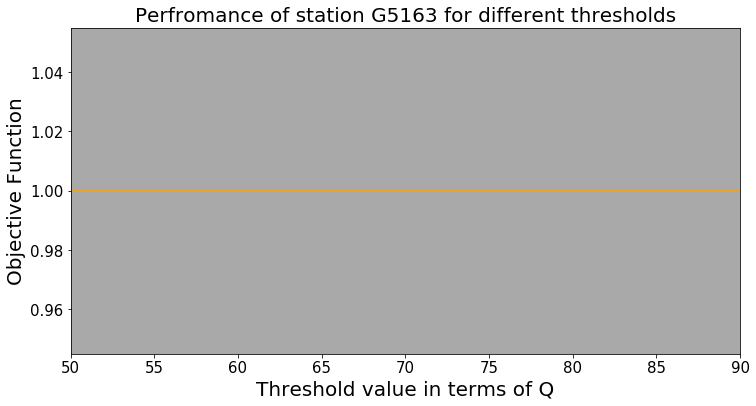

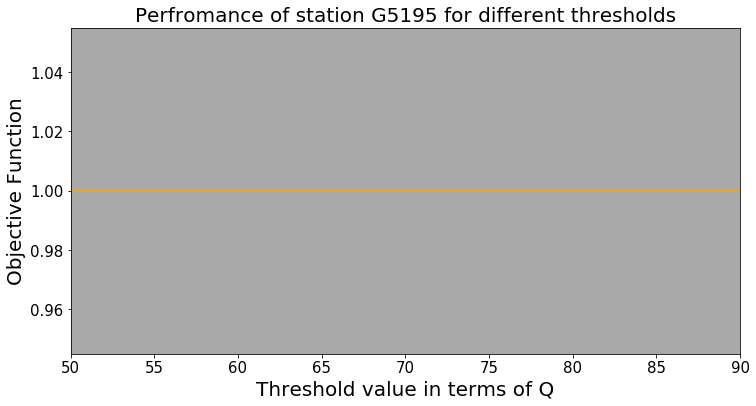

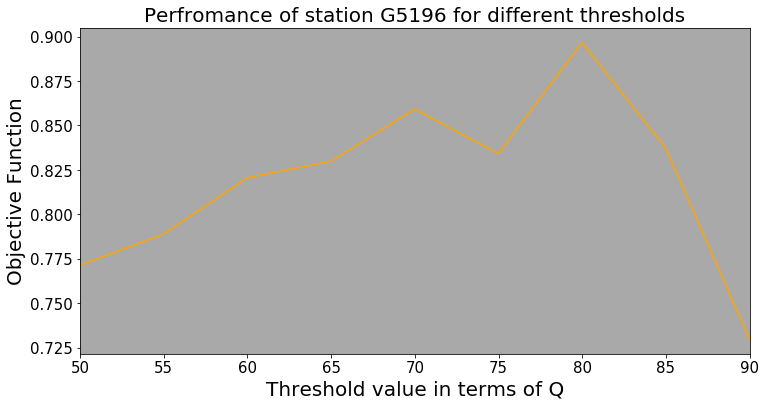

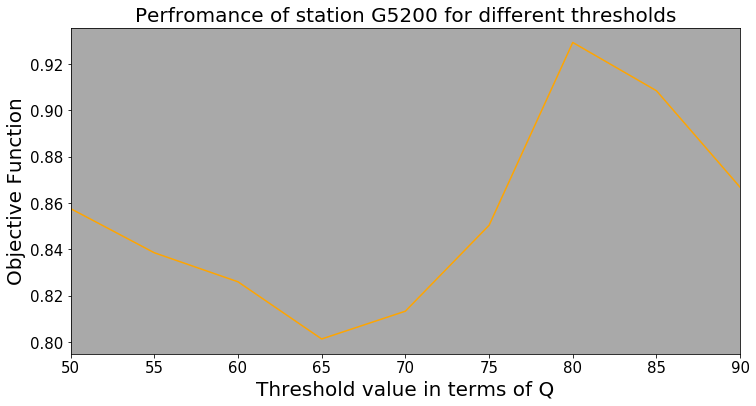

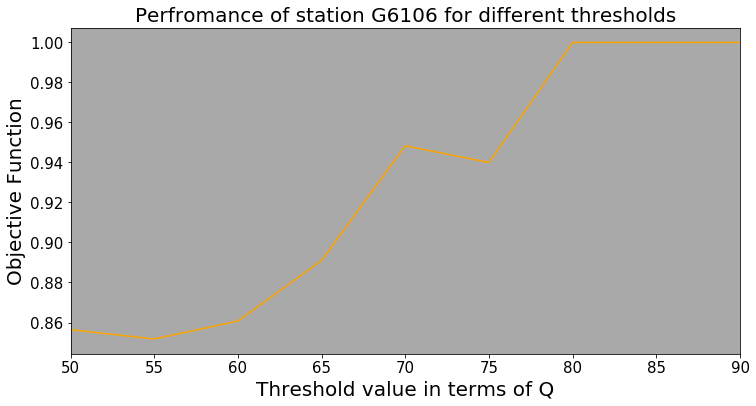

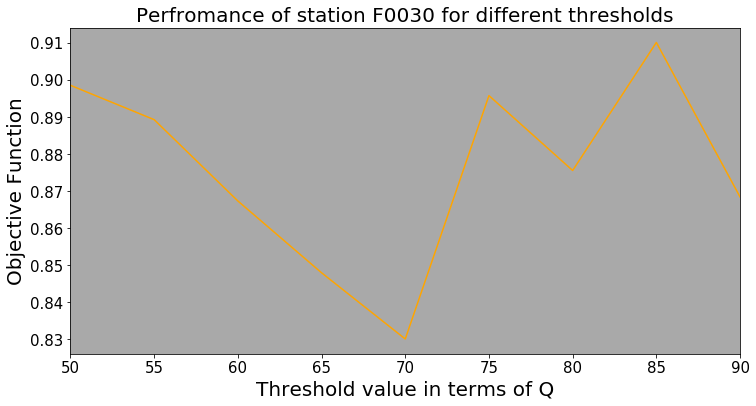

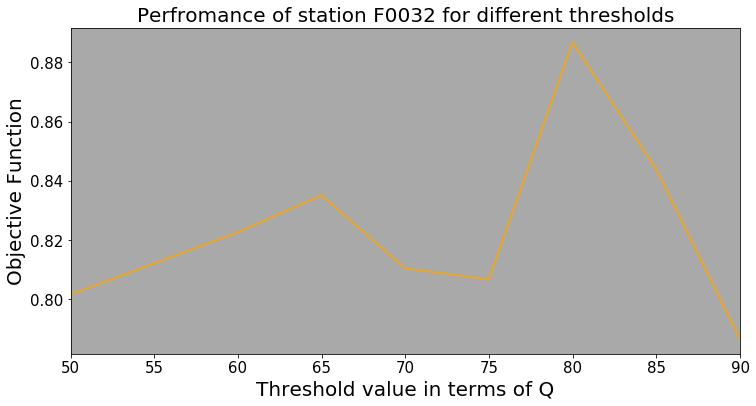

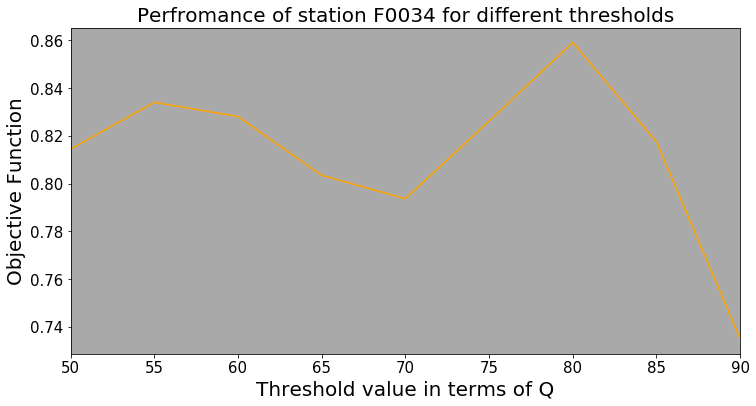

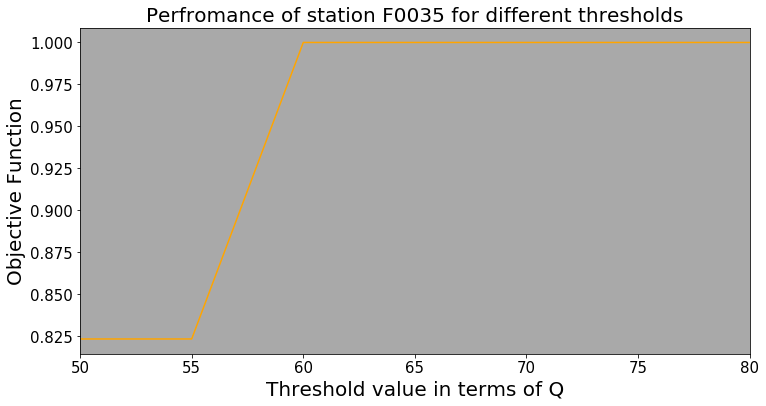

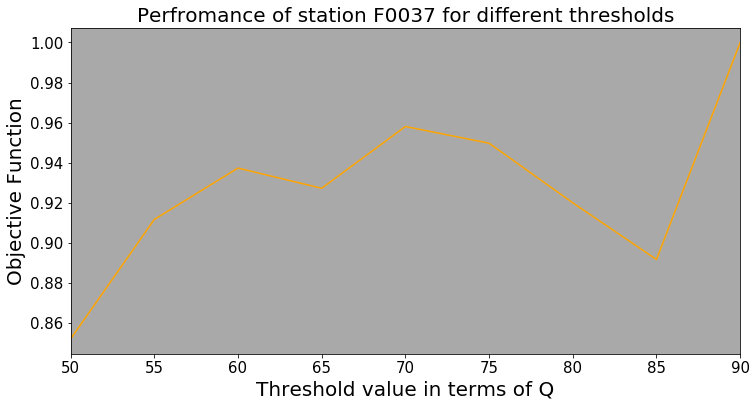

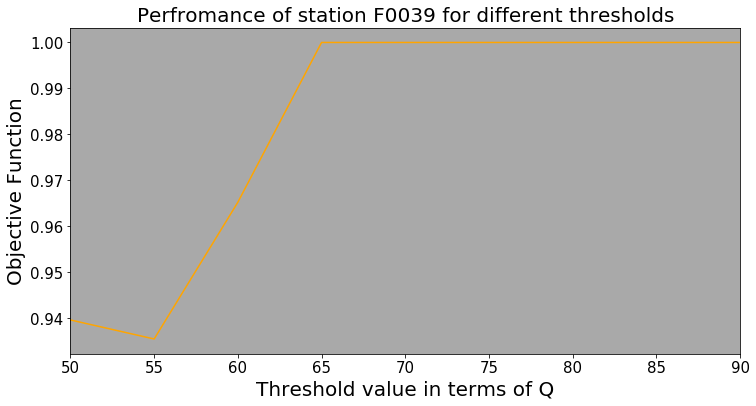

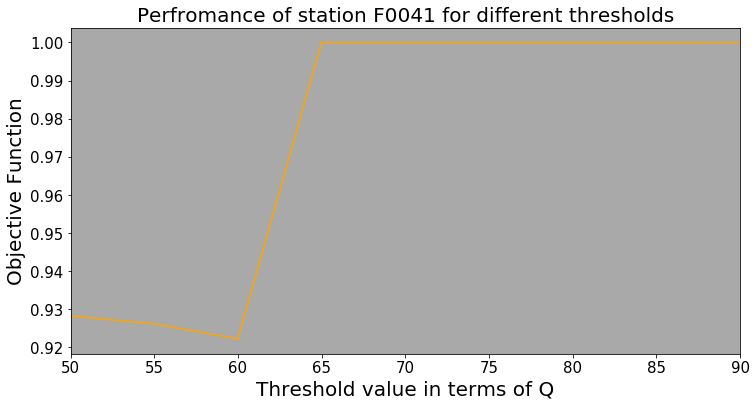

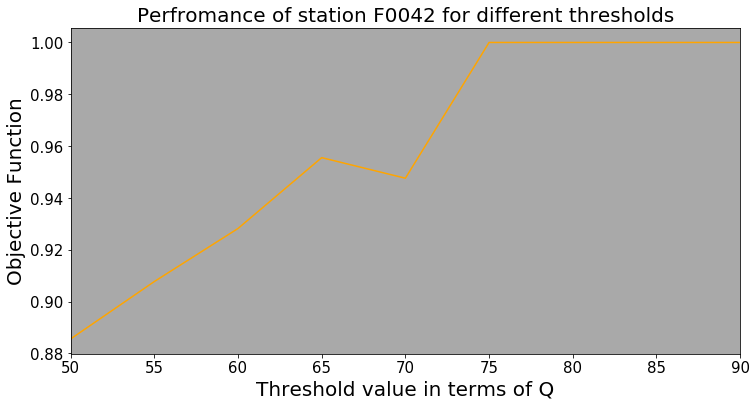

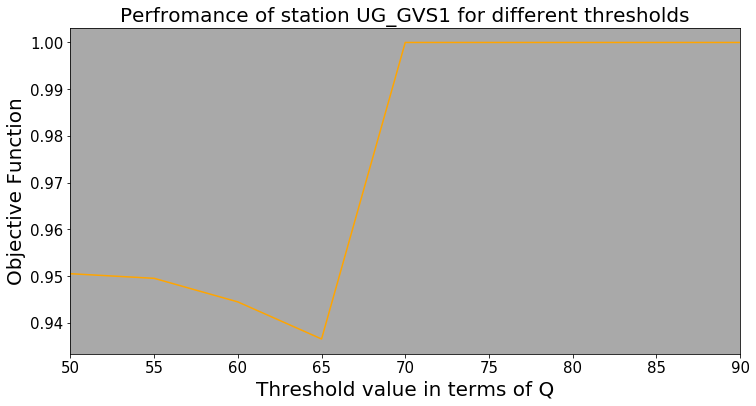

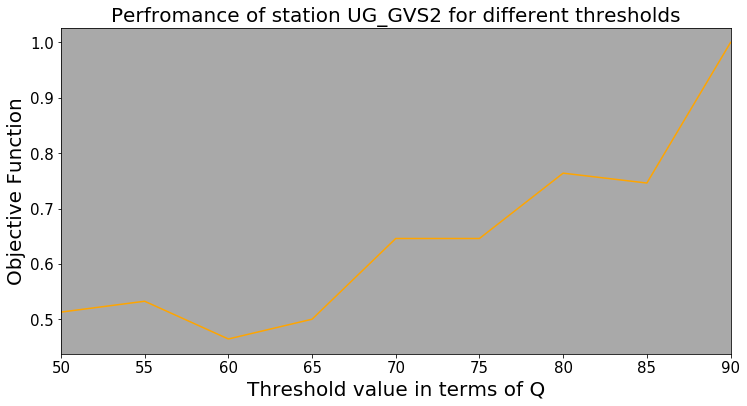

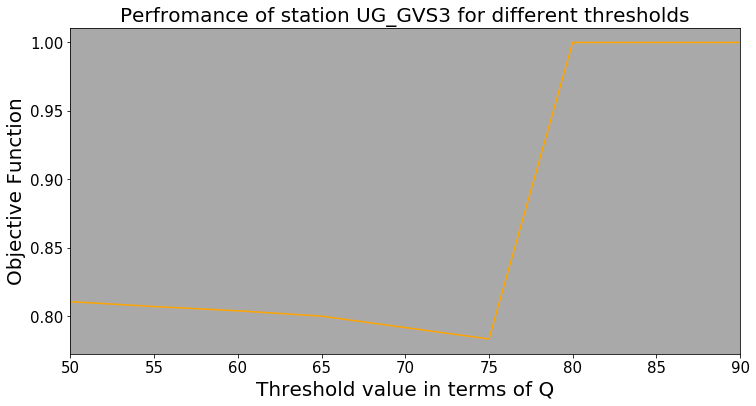

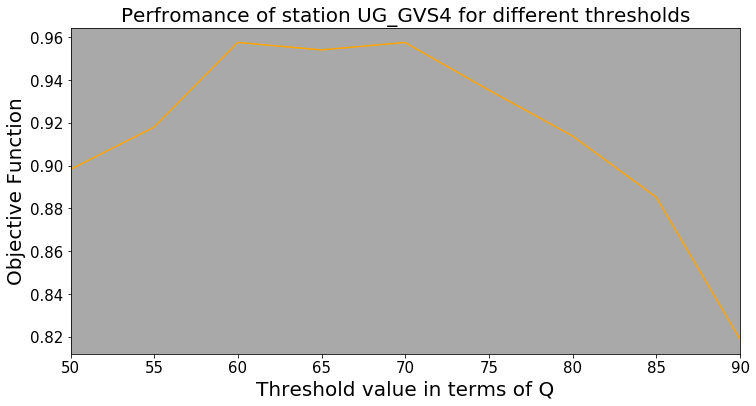

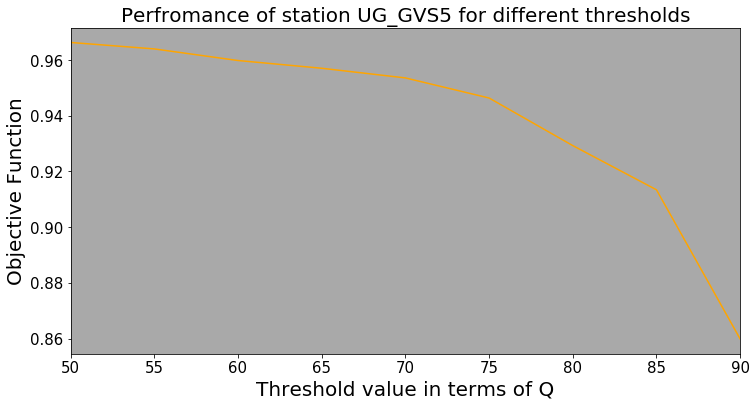

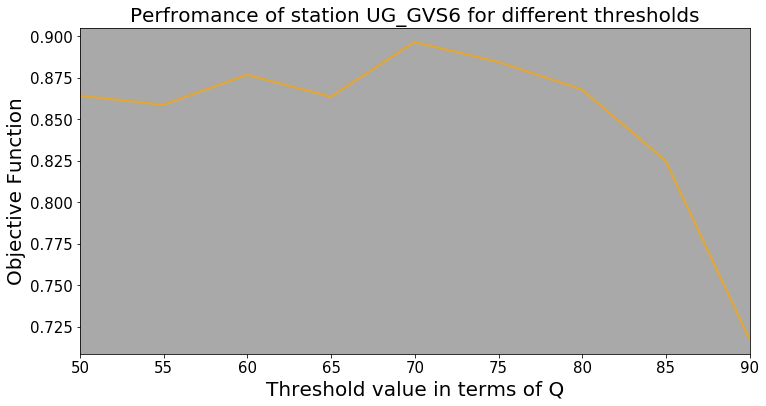

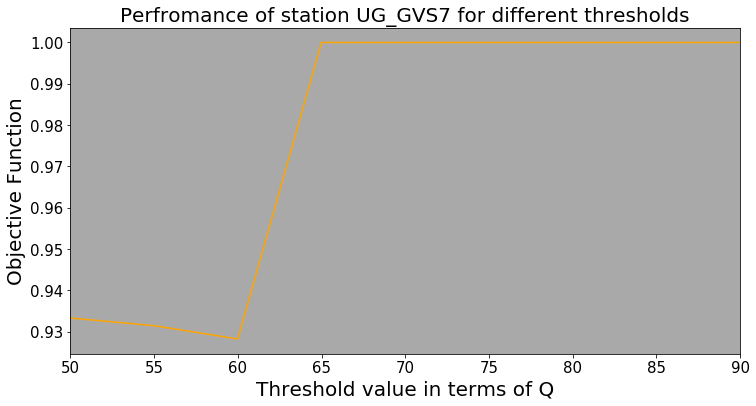

In [89]:
for station in tot_perf['station'].unique():
    tot_perf_st = tot_perf[tot_perf['station']== station]
    ax=tot_perf_st.plot(x='threshold_num',y='objective_function',legend=False,figsize=(12,6),color="orange")
    plt.ylabel('Objective Function',fontsize=20)
    plt.xlabel('Threshold value in terms of Q',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.set_facecolor('darkgray')
    plt.title('Perfromance of station ' + station + ' for different thresholds',fontsize=20)  
    plt.savefig('Optimized_performances/' + station + '.png')

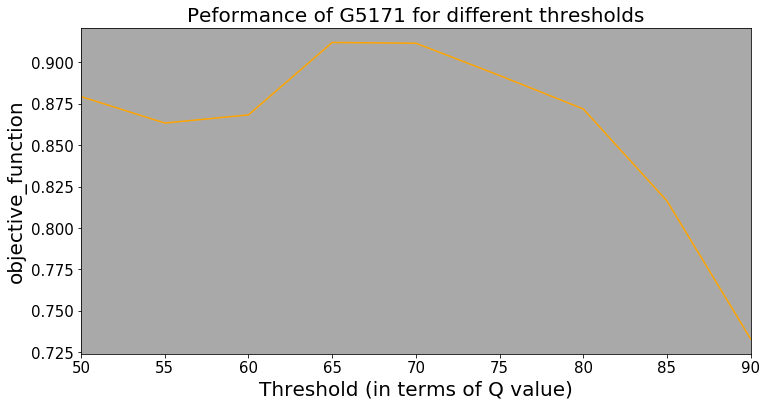

In [86]:
    tot_perf_st = tot_perf[tot_per['station']== station]
    tot_perf_st.plot(x='threshold_num',y='objective_function')

# Testing and adjustments

1.0